## Loading Dataset and Importing Libraries:

In [401]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import tensorflow as tf 
import gensim
import spacy
import nltk
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.utils import shuffle # we can also shuffle in input_func with tensorflow
warnings.filterwarnings("ignore")

%matplotlib inline

In [388]:
df = pd.read_csv('SEM_KeyWord_Dataset.csv')

In [389]:
df.head()

,Date,Market,Keyword,Average.Position,CPC,Clicks,CTR,Impressions,Cost
0,20120524,US-Market,secure online back up,0.0,0.0,0.00,0.00%,0.0,0.00
1,20120524,US-Market,agile management software,1.0,1.2,21.22,8.20%,260.0,25.45
2,20120524,US-Market,crm for financial,0.0,0.0,0.00,0.00%,0.0,0.00
3,20120524,US-Market,disaster recovery planning for it,0.0,0.0,0.00,0.00%,0.0,0.00
4,20120524,US-Market,tracking a vehicle,0.0,0.0,0.00,0.00%,0.0,0.00


In [380]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 352540 entries, 0 to 356053
Data columns (total 9 columns):
Date                352540 non-null int64
Market              352540 non-null object
Keyword             352540 non-null object
Average.Position    352540 non-null float64
CPC                 352540 non-null float64
Clicks              352540 non-null float64
CTR                 352540 non-null float64
Impressions         352540 non-null float64
Cost                352540 non-null float64
dtypes: float64(6), int64(1), object(2)
memory usage: 26.9+ MB


In [381]:
df.describe()

,Date,Average.Position,CPC,Clicks,CTR,Impressions,Cost
count,3.525400e+05,352540.000000,352540.000000,352540.000000,352540.000000,3.525400e+05,352540.000000
mean,2.012271e+07,0.611163,14.287964,220.299838,1.630900,9.758862e+03,1900.441204
std,3.589467e+03,0.644052,37.882436,1719.222177,2.033744,7.145521e+04,10060.075649
min,2.012052e+07,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,2.012090e+07,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
50%,2.012102e+07,1.000000,1.080000,2.090000,0.800000,1.270000e+02,7.930000
75%,2.012122e+07,1.000000,12.070000,34.870000,2.800000,1.553000e+03,369.810000
max,2.013021e+07,12.000000,632.730000,89233.580000,23.700000,3.666042e+06,285716.050000


## Data Pre-processing:

In [390]:
df['CTR'] = df['CTR'].apply(lambda x: float(str(x).replace('%', ''))) # remove extra character string

df = df.dropna() # drop the null values 

# df['Market'] = pd.get_dummies(df['Market']) # set dummies for market feature (binary)

df.head() # check head

,Date,Market,Keyword,Average.Position,CPC,Clicks,CTR,Impressions,Cost
0,20120524,US-Market,secure online back up,0.0,0.0,0.00,0.0,0.0,0.00
1,20120524,US-Market,agile management software,1.0,1.2,21.22,8.2,260.0,25.45
2,20120524,US-Market,crm for financial,0.0,0.0,0.00,0.0,0.0,0.00
3,20120524,US-Market,disaster recovery planning for it,0.0,0.0,0.00,0.0,0.0,0.00
4,20120524,US-Market,tracking a vehicle,0.0,0.0,0.00,0.0,0.0,0.00


In [392]:
print(df['Market'].nunique())
print(df['Market'].value_counts())

# since market is an important column, on which we'll be forecasting
# we need to somehow use this in our training data

2
US-Market    229163
UK-Market    123377
Name: Market, dtype: int64


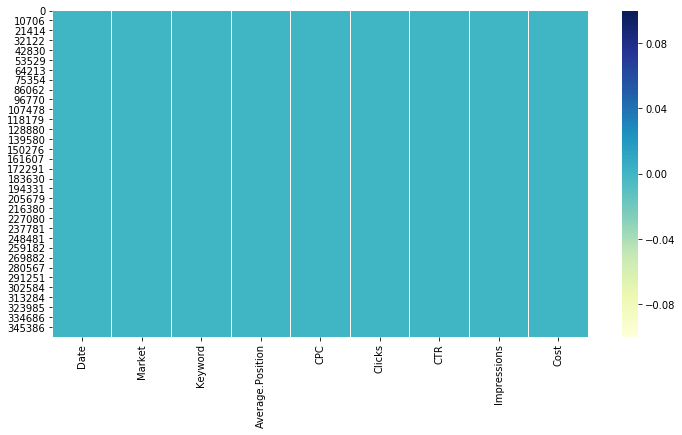

In [397]:
# Let's quickly make sure we are not left with any null value in out data set
plt.figure(figsize = (12,6))
sns.heatmap(df.isnull(), cmap = 'YlGnBu')

In [448]:
# Now as we can see we have a lot of values that are "zeros"
# having those values in our data set make the model not learn properly and might overfit
# due to the repeated nature. So we might wanna eliminate those zero values 
# from our data set 

mapped_market = {'US-Market': 0, 'UK-Market': 1}

new_df = df[df['CPC'] != 0]
new_df['Market'] = new_df["Market"].map(mapped_market) # map the market values with 1's and 0's
new_df.info() # new data set with "CPC" not equals to "Zero"
new_df.head(10)

# Now we have 2 data sets
# one with all the observations i.e with "CPC" having zero values
# other, having "CPC" not equals to zero

<class 'pandas.core.frame.DataFrame'>
Int64Index: 203595 entries, 1 to 356039
Data columns (total 9 columns):
Date                203595 non-null int64
Market              203595 non-null int64
Keyword             203595 non-null object
Average.Position    203595 non-null float64
CPC                 203595 non-null float64
Clicks              203595 non-null float64
CTR                 203595 non-null float64
Impressions         203595 non-null float64
Cost                203595 non-null float64
dtypes: float64(6), int64(2), object(1)
memory usage: 15.5+ MB


,Date,Market,Keyword,Average.Position,CPC,Clicks,CTR,Impressions,Cost
1,20120524,0,agile management software,1.0,1.20,21.22,8.2,260.0,25.45
9,20120524,0,android app developers,1.0,0.66,23.31,8.6,270.0,15.31
13,20120524,0,android application developer,1.0,1.02,46.92,8.6,546.0,47.77
14,20120524,0,android app developer,1.0,1.30,147.46,6.0,2469.0,191.99
17,20120524,0,mobile applications developers,1.0,0.57,21.69,8.3,260.0,12.31
19,20120524,0,cloud computing for dummies,1.0,0.50,37.89,11.4,330.0,19.10
24,20120524,0,apps development,1.0,0.69,23.69,5.5,433.0,16.25
27,20120524,0,mobile apps developers,1.0,2.53,22.94,4.3,529.0,58.04
28,20120524,0,joomla designers,1.0,1.37,17.84,6.6,268.0,24.36
44,20120524,0,ink 8560,1.0,1.59,0.26,0.1,216.0,0.41


In [449]:
new_df = shuffle(new_df)
new_df.head()

,Date,Market,Keyword,Average.Position,CPC,Clicks,CTR,Impressions,Cost
181217,20121120,0,quotes,1.0,0.61,1413.83,2.3,61989.0,865.11
76036,20121125,0,att go,1.0,0.57,16.29,3.6,446.0,9.23
189221,20121203,0,credit card services,1.0,20.30,118.50,4.1,2899.0,2405.90
334473,20130105,1,consumer credit,1.0,6.25,5.34,2.0,265.0,33.42
308438,20121125,1,adwords marketing,1.0,48.88,2.25,3.5,64.0,109.89


## Data Visualization:

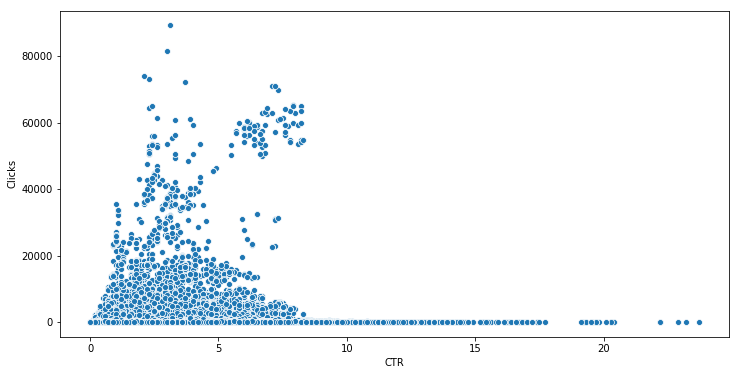

In [450]:
plt.figure(figsize = (12,6))
sns.scatterplot(x = new_df['CTR'], y = new_df['Clicks'])

<Figure size 864x432 with 0 Axes>

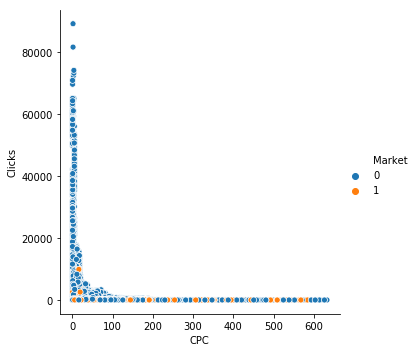

In [451]:
plt.figure(figsize = (12,6))
sns.relplot(x = 'CPC', y = 'Clicks', data = new_df, hue = 'Market')

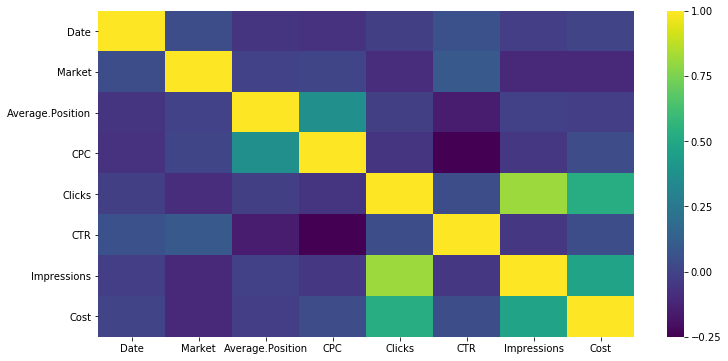

In [441]:
corr = new_df.corr()

plt.figure(figsize = (12,6))
sns.heatmap(data = corr, cmap = 'viridis')

In [67]:
X = new_df.drop(['Date', 'Clicks', 'Keyword'], axis = 1)
y = new_df['Clicks']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=101)

In [68]:
model = LinearRegression()

In [69]:
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [70]:
predictions = model.predict(X_test)

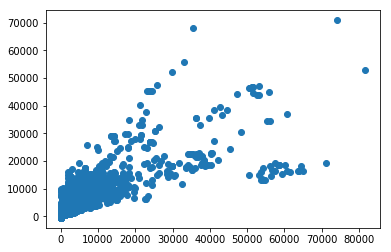

In [71]:
from sklearn import metrics

plt.scatter(y_test, predictions)

In [72]:
metrics.mean_absolute_error(y_test, predictions)

259.72876628364185

In [73]:
(metrics.mean_squared_error(y_test, predictions) ** 0.5)

1235.4746097966586

/home/umairshah/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


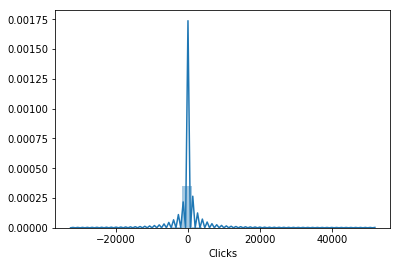

In [74]:
sns.distplot((y_test-predictions), bins = 30)

In [75]:
metrics.r2_score(y_test, predictions)

0.7076517852325654

## Correlations:

In [76]:
corr = new_df.corr()

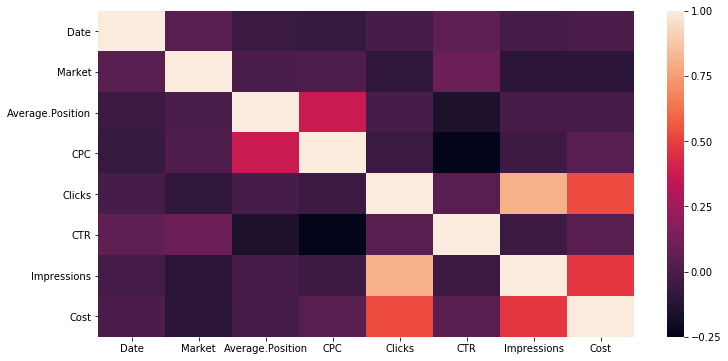

In [226]:
plt.figure(figsize = (12,6))
sns.heatmap(corr)

In [78]:
new_df['Clicks'].corr(new_df['Cost'])

0.5307991295567502

In [79]:
X1 = new_df.drop(['Date', 'CTR', 'Average.Position', 'Clicks'], axis = 1)
y1 = new_df['Clicks']

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.33, random_state=101)

In [80]:
model = LinearRegression()

In [81]:
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [82]:
predictions = model.predict(X_test)

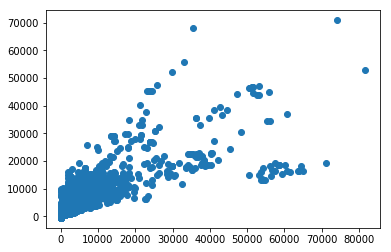

In [83]:
from sklearn import metrics
plt.scatter(y_test, predictions)

In [84]:
metrics.mean_absolute_error(y_test, predictions)

259.72876628364185

In [85]:
(metrics.mean_squared_error(y_test, predictions) ** 0.5)

1235.4746097966586

/home/umairshah/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


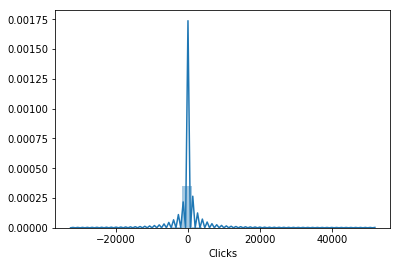

In [86]:
sns.distplot((y_test-predictions), bins = 30)

In [87]:
metrics.r2_score(y_test, predictions)

0.7076517852325654

## Ridge Regression:

In [88]:
from sklearn import linear_model

reg = linear_model.LassoLars(alpha = 0.1)

reg.fit(X_train, y_train)

LassoLars(alpha=0.1, copy_X=True, eps=2.220446049250313e-16,
     fit_intercept=True, fit_path=True, max_iter=500, normalize=True,
     positive=False, precompute='auto', verbose=False)

In [89]:
reg_predictions = reg.predict(X_test)

In [90]:
metrics.r2_score(y_test, reg_predictions)

0.7065768306821503

## Keyword Preprocessing

In [91]:
words_list = list(df['Keyword'])

final_list = []

for segment in words_list:
    new_list = segment.split()
    for i in new_list:
        final_list.append(i)
        
word_dict = {}

for word in final_list:
    if word in word_dict:
        word_dict[word] += 1
    else:
        word_dict[word] = 1
        
print(set(final_list))
print(set(word_dict))

print(len(set((final_list))))

{'cloud', 'commercial', 'sql', 'electricity', 'Los', 'index', 'call', 'security', 'disease', 'finepix', 'apprendimento', 'illness', 'your', 'iphone', 'dish', 'flu', 'crm', 'snooki', 'payday', 'dvd', 'ohio', 'trader', 'машинное', 'consolidation', 'commodities', 'sky', 'grooveshark', 'claims', 'locks', 'money', 'removal', 'randy', 'gomez', 'gift', 'college', 'developers', 'photography', 'monitors', 'claim', 'wayne', 'Adsense', 'University', 'disney', 'anti', 'drug', 'deal', 'remortgage', 'grange', 'youtube', 'nfp', 'uk', '100', 'earthquake', 'ink', 'menowin', 'comparison', 'sims', 'words', 'drive', 'martial', 'kim', 'суши', 'employee', 'shavers', 'of', 'mundial', 'gostoso', '3g', 'prices', 'points', 'olympics', 'tours', 'pizza', 'knight', 'optimization', 'harrison', 'glaze', 'd90', 'laptop', 'haiti', 'mortgage', 'notes', 'solar', 'cross', 'apply', 'my', 'facebook', 'fee', 'rebate', 'bryant', 'payments', 'lotus', 'dual', 'heat', 'scott', 'megan', 'services', 'antonio', 'reward', 'desk', '

In [92]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

nlp = spacy.load('en_core_web_sm')

def remove_stops(text):
    my_doc = nlp(text)
    token_list = []
    filtered_sentence = []
    
    for token in my_doc:
        token_list.append(token.text)
        
    for word in token_list:
        lexeme = nlp.vocab[word]
        if lexeme.is_stop == False:
            filtered_sentence.append(word)
            
    return " ".join(filtered_sentence)

In [93]:
remove_stops("tracking a vehicle")

'tracking vehicle'

In [94]:
new_df['Keyword'].head()

286428     credit card company
163763    life insurance quote
293225               mortgages
217868      debt consolidation
200937           school quotes
Name: Keyword, dtype: object

In [95]:
new_df['Keyword'][10:100].apply(remove_stops)

180925                     credit report
157242                     gmac mortgage
126618                    college credit
152178                   credit card apr
37040                       donate haiti
196459                       line credit
23182                             credit
240125                         mortgages
270831                  zurich insurance
341978      credit card balance transfer
82147                     james harrison
212671               domain registration
194798                               dui
131925                      equity loans
242957                 mercury insurance
237021                 apply credit card
289563                 visa credit cards
118159                             money
134837              credit card services
118400                       scott trade
135491                       oil futures
152732             auto insurance quotes
280274                 consolidate loans
204171            stock trading software
273080         l

In [96]:
word_list = 'this is a word list and list word'.split()

word_dict = {}

for word in word_list:
    if word in word_dict:
        word_dict[word] += 1
    else:
        word_dict[word] = 1
        
print(word_list)
print(word_dict)

filtered_words = set(word_dict)
print(filtered_words)

['this', 'is', 'a', 'word', 'list', 'and', 'list', 'word']
{'this': 1, 'is': 1, 'a': 1, 'word': 2, 'list': 2, 'and': 1}
{'this', 'list', 'is', 'word', 'a', 'and'}


## Neural Network Model:

In [131]:
import tensorflow as tf

In [305]:
new_df['Market'].unique()

array(['US-Market', 'UK-Market'], dtype=object)

In [358]:
X = new_df.drop(['Market', 'Average.Position', 'Clicks', 'Date',], axis = 1)
y = new_df['Clicks']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.8, random_state = 101)

In [360]:
X.head()

,Keyword,CPC,CTR,Impressions,Cost
185025,comcast high speed,10.05,2.9,356.0,103.42
158238,home equity loans,44.35,1.4,2247.0,1382.94
225072,one credit card,67.32,2.3,591.0,933.65
189721,commercial auto insurance,40.61,4.8,663.0,1304.03
197836,chase credit,16.46,2.7,2071.0,904.33


In [350]:
X.columns

Index(['CPC', 'CTR', 'Impressions', 'Cost'], dtype='object')

In [369]:
keyword = tf.feature_column.categorical_column_with_hash_bucket("keyword", hash_bucket_size = 1000)

feat_cols = []

for col in X.columns:
    col = tf.feature_column.numeric_column(col)
    feat_cols.append(col)

feat_cols.append(keyword)

feat_cols

[NumericColumn(key='Keyword', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='CPC', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='CTR', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='Impressions', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='Cost', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 HashedCategoricalColumn(key='keyword', hash_bucket_size=1000, dtype=tf.string)]

In [370]:
len(feat_cols)

6

In [371]:
X_train.shape

(40719, 5)

In [372]:
y_train.shape

(40719,)

In [373]:
## 2) Input Function

input_func = tf.estimator.inputs.pandas_input_fn(x = X_train, y = y_train,
                                                batch_size = 64, num_epochs = 1000,
                                                shuffle = True)

In [374]:
len(feat_cols)

6

In [375]:
## 3) Estimator Model

model = tf.estimator.DNNRegressor(hidden_units = [8,8,8], feature_columns = feat_cols)

W1024 20:00:14.262848 139667087357760 estimator.py:1811] Using temporary folder as model directory: /tmp/tmp1ranfg6i


In [376]:
model.train(input_fn = input_func, steps = 200)

ValueError: Items of feature_columns must be a <class 'tensorflow.python.feature_column.feature_column_v2.DenseColumn'>. You can wrap a categorical column with an embedding_column or indicator_column. Given: HashedCategoricalColumn(key='keyword', hash_bucket_size=1000, dtype=tf.string)

In [276]:
predict_input_func = tf.estimator.inputs.pandas_input_fn(x = X_test, batch_size = 64,
                                                        num_epochs = 1, shuffle = True)

In [277]:
pred_generator = model.predict(input_fn = predict_input_func)

In [278]:
predictions = list(pred_generator)

In [279]:
final_predictions = [pred["predictions"] for pred in predictions]
final_predictions
print(len(final_predictions))

282032


In [280]:
from sklearn.metrics import mean_squared_error

MSE = mean_squared_error(y_test, final_predictions) ** 0.5

print(MSE)

2020.7134591653312


In [281]:
from sklearn.metrics import r2_score

In [282]:
print("Model Accuracy: {0:0.3f}".format(r2_score(y_test, final_predictions)))

Model Accuracy: -0.357


In [222]:
new_df.head(10)

,Date,Market,Keyword,Average.Position,CPC,Clicks,CTR,Impressions,Cost
286428,20121020,1,credit card company,1.0,0.48,12.26,7.7,159.0,5.89
163763,20121021,0,life insurance quote,1.0,15.82,22.34,1.7,1343.0,353.57
293225,20121101,1,mortgages,1.0,10.27,1098.48,2.4,45002.0,11281.14
217868,20130117,0,debt consolidation,1.0,52.70,375.10,1.9,19399.0,19768.77
200937,20121221,0,school quotes,1.0,0.22,0.16,0.2,89.0,0.03
119768,20120811,0,small business credit cards,1.0,12.59,34.60,5.1,677.0,435.61
262599,20120912,1,ways to make money,1.0,11.20,2.88,0.6,516.0,32.28
151332,20120930,0,consolidate student loans,1.0,27.73,6.03,0.6,957.0,167.16
331028,20121231,1,apply credit cards,1.0,64.33,4.37,4.3,100.0,280.87
90855,20121229,0,primary pulmonary hypertension,1.0,6.96,1.96,1.0,189.0,13.66


In [407]:
new_df.head()

,Date,Market,Keyword,Average.Position,CPC,Clicks,CTR,Impressions,Cost
219232,20130119,US-Market,webhost,1.0,2.10,5.16,1.1,473.0,10.85
188445,20121201,US-Market,credit cards com,1.0,16.39,121.46,5.2,2324.0,1990.82
133098,20120902,US-Market,college credit,1.0,358.08,0.00,0.0,136.0,1.71
224183,20130127,US-Market,credit cards for students,1.0,65.64,20.75,3.7,559.0,1362.04
111030,20120728,US-Market,money fast,1.0,4.58,33.65,4.2,794.0,154.07


In [429]:
max_entry_len = max([len(string.split()) for string in list(new_df['Keyword'])])

min_entry_len = min([len(string.split()) for string in list(new_df['Keyword'])])

print(max_entry_len)
print(min_entry_len)

6
1


In [431]:
max_entry_len_previous = max([len(string.split()) for string in list(df['Keyword'])])

min_entry_len_previous = min([len(string.split()) for string in list(df['Keyword'])])

print(max_entry_len_previous)
print(min_entry_len_previous)

8
1
